<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-Data" data-toc-modified-id="Loading-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading Data</a></span></li><li><span><a href="#Filtering" data-toc-modified-id="Filtering-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Filtering</a></span></li><li><span><a href="#Normalization" data-toc-modified-id="Normalization-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Normalization</a></span></li><li><span><a href="#Visualization" data-toc-modified-id="Visualization-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Visualization</a></span><ul class="toc-item"><li><span><a href="#PCA" data-toc-modified-id="PCA-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>PCA</a></span></li><li><span><a href="#UMAP" data-toc-modified-id="UMAP-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>UMAP</a></span></li></ul></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict, Counter, OrderedDict

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import sklearn.manifold
from sklearn.decomposition import PCA

import phenograph

from scipy.sparse import csr_matrix, find, issparse

import warnings
warnings.filterwarnings("ignore")

import scanpy as scanpy
import time
import scipy
import umap

/Users/burdziac/homebrew/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numba-0.40.1-py3.6-macosx-10.11-x86_64.egg/numba/errors.py:102: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
import os 
os.chdir("../../")
from scutils_cnb import *

In [3]:
palette =  {0:"#000000",1:"#010067",2:"#D5FF00",3:"#FF0056",4:"#9E008E", 5:"#0E4CA1", 6:"#FFE502", 7:"#005F39", 8:"#00FF00", 9:"#95003A",10:"#FF937E",
          11:"#A42400", 12:"#001544", 13:"#91D0CB",14:"#620E00",15:"#6B6882",16:"#0000FF",17:"#007DB5",18:"#6A826C",19:"#00AE7E",20:"#C28C9F",
          21:"#BE9970",22:"#008F9C",23:"#5FAD4E",24:"#FF0000", 25:"#FF00F6",26:"#FF029D",27:"#683D3B",28:"#FF74A3",29:"#968AE8",30:"#98FF52",
          31:"#A75740",32:"#01FFFE",33:"#FFEEE8",34:"#FE8900",35:"#BDC6FF",36:"#01D0FF",37:"#BB8800",38:"#7544B1",39:"#A5FFD2",40:"#FFA6FE",
          41:"#774D00", 42:"#7A4782", 43:"#263400", 44:"#004754", 45:"#43002C", 46:"#B500FF", 47:"#FFB167", 48:"#FFDB66", 49:"#90FB92",
          50:"#7E2DD2", 51:"#BDD393", 52:"#E56FFE", 53:"#DEFF74", 54:"#00FF78", 55:"#009BFF", 56:"#006401", 57:"#0076FF", 58:"#85A900", 59:"#00B917",
          60:"#788231", 61:"#00FFC6", 62:"#FF6E41", 63:"#E85EBE"}
palette[70] = "#FFFFFF"

In [4]:
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100

# Loading Data

In [5]:
sample = 'KateMerge_10bp'

path_h5 = '/Users/burdziac/Documents/PDAC/data/scATACseq/'
suffix_h5  = 'filtered_peak_bc_matrix.h5'

In [6]:
# open peaf and TF file
adata = scanpy.read_10x_h5(path_h5 + sample + "/" + suffix_h5, genome=None, gex_only=False)

In [7]:
peaks = np.array(adata.var['gene_ids'])
data = adata.X.copy()

In [8]:
sample_ids = np.array(list(adata.obs.index))
sample_ids = [sample.split("-")[1] for sample in sample_ids]
del adata

In [9]:
# UPDATE PEAK BY THE NAME OF CLOSEST TSS

# For each file use bedtools to identify closest TSS ()
closest_tss = pd.read_table('/Users/burdziac/Documents/PDAC/data/scATACseq/' + sample + '/closesttss.csv', header= None)
closest_tss.columns = ['chr','pos1', 'pos2','closest_chr','closest_pos1', 'closest_pos2', 'gene','distance'  ]
closest_tss['distance1'] = abs(closest_tss.pos1 - closest_tss.closest_pos1)
closest_tss['distance2'] = abs(closest_tss.pos2 - closest_tss.closest_pos2)
closest_tss['distancemin'] = closest_tss[["distance1", "distance2"]].min(axis=1)
closest_tss['width'] = abs(closest_tss.pos1 - closest_tss.pos2)

#Update index as chr coordinates
closest_tss.index = closest_tss.chr.astype(str).str.cat(closest_tss.pos1.astype(str), sep=':')
closest_tss.index = closest_tss.index.astype(str).str.cat(closest_tss.pos2.astype(str), sep='-')

# Keep only closest TSS that are inclused in adata.var[]
closest_tss = closest_tss.loc[closest_tss.index.isin(list(peaks)),:]

# Remove dupplicate chr positions
closest_tss = closest_tss[~closest_tss.index.duplicated(keep='first')]

# Clean gene names
closest_tss['gene_clean'] = [i.split('.', 1)[0] for i in list(closest_tss.gene)]

print(closest_tss.shape)
closest_tss.head(5)

(152991, 13)


,chr,pos1,pos2,closest_chr,closest_pos1,closest_pos2,gene,distance,distance1,distance2,distancemin,width,gene_clean
chr,,,,,,,,,,,,,
chr1:3493532-3494115,chr1,3493532,3494115,chr1,3466587,3466588,Gm1992,26945,26945,27527,26945,583,Gm1992
chr1:3514498-3515608,chr1,3514498,3515608,chr1,3466587,3466588,Gm1992,47911,47911,49020,47911,1110,Gm1992
chr1:3534683-3535113,chr1,3534683,3535113,chr1,3466587,3466588,Gm1992,68096,68096,68525,68096,430,Gm1992
chr1:3535378-3535755,chr1,3535378,3535755,chr1,3466587,3466588,Gm1992,68791,68791,69167,68791,377,Gm1992
chr1:3551128-3551665,chr1,3551128,3551665,chr1,3466587,3466588,Gm1992,84541,84541,85077,84541,537,Gm1992


In [10]:
genes = closest_tss['gene_clean']
genes_promoters = closest_tss.iloc[np.where(closest_tss['distance'] < 500)[0]][['gene_clean','distance']]

genes_all = closest_tss.iloc[np.where(closest_tss['distance'] < 10000)[0]][['gene_clean','distance']]
genes_all = pd.DataFrame(np.arange(len(peaks)),index=peaks).merge(genes_all,left_index=True,right_index=True,how='right')

# Filtering

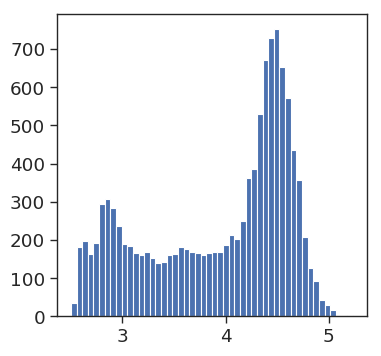

In [11]:
plt.hist(np.log10(data.sum(1)), bins = 50)
plt.show()

In [13]:
#keep_peaks = np.where(data_bin.sum(0)>10)[0]
keep_cells = np.where(np.log10(data.sum(1))>4.1)[0]

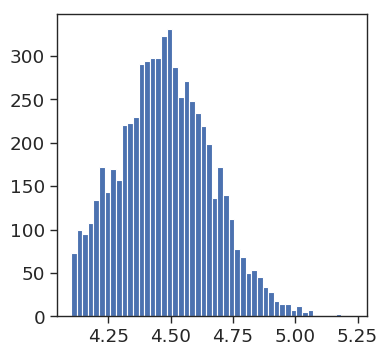

In [14]:
data = scipy.sparse.csr_matrix(data.toarray()[keep_cells,:])
data_bin = scipy.sparse.csr_matrix((data.toarray()>0.0).astype(np.int_))
sample_ids = np.array(sample_ids).astype(np.float32)[keep_cells]
#peaks = peaks[keep_peaks]
plt.hist(np.log10(data.sum(1)), bins = 50);

# Normalization

In [15]:
coverage = np.array(data.sum(1))

In [16]:
model = sklearn.linear_model.LinearRegression(normalize=False,n_jobs = 10)
model = model.fit(X=coverage,y=data_bin.toarray())

In [17]:
start = [int(peak.split(":")[1].split("-")[0]) for peak in peaks]
stop = [int(peak.split(":")[1].split("-")[1]) for peak in peaks]
width = np.array(stop) - np.array(start) + 1
upper=2000
lower=2
keep = (width<upper) * (width>lower)

In [18]:
data_corrected = data_bin - model.predict(coverage) 

data_corrected = data_corrected[:,np.where(keep)[0]]

# Visualization

## PCA

In [19]:
pca = PCA(n_components=100)
pc = pca.fit_transform(data_corrected)

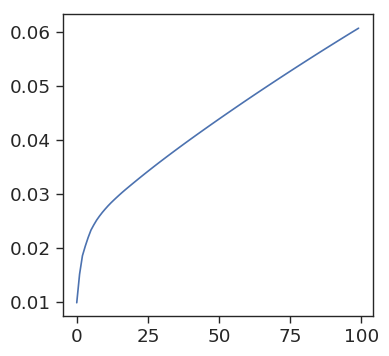

In [20]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

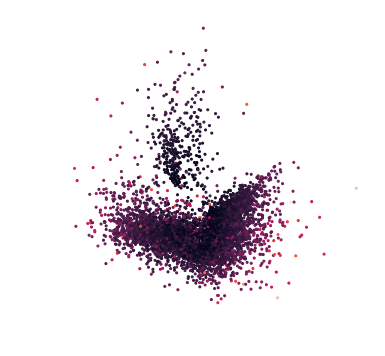

In [21]:
plt.scatter(pc[:,0],pc[:,1],s=2,c=coverage.flatten())
plt.axis("off");

## UMAP

In [32]:
#code is commented out; reading in exact version from paper
#embedding = umap.UMAP(n_neighbors=30,min_dist=.3).fit_transform(pc[:,:20])
embedding = pickle.load(open("scATAC/outputs/KateAggr_10bp_Playing_embedding_option2.p",'rb'))

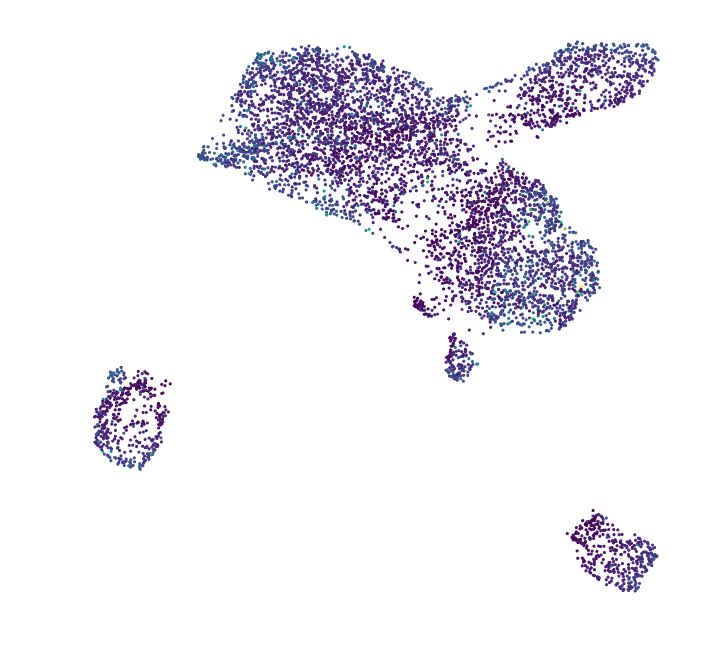

In [33]:
#PBS
fig,ax = plt.subplots(figsize=(8,8))

ax.scatter(embedding[:,0],embedding[:,1], c=coverage.flatten() ,s=2,cmap='viridis')

ax.set_axis_off();

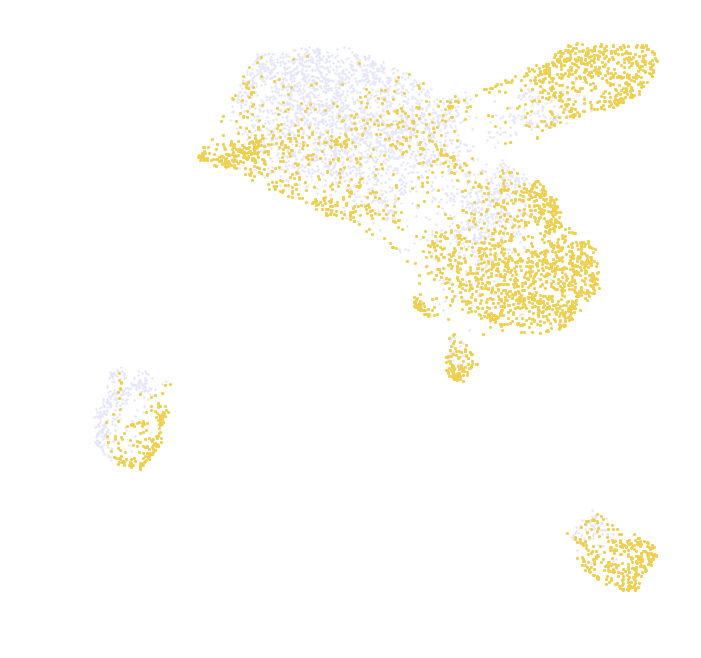

In [34]:
#PBS
fig,ax = plt.subplots(figsize=(8,8))

ax.scatter(embedding[:,0],embedding[:,1],s=1, c='lavender')
ax.scatter(embedding[:,0][sample_ids==2],embedding[:,1][sample_ids==2],s=2, c='#EED04D')

ax.set_axis_off();
#plt.savefig("/Users/burdziac/Documents/PDAC/notebooks/scATAC/figures/UMAP_PBS_newcolors.pdf")

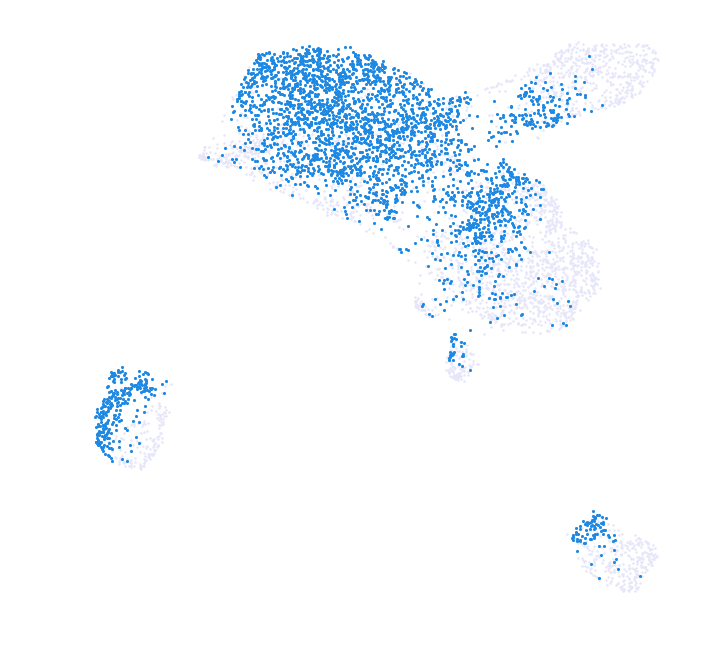

In [35]:
#PBS
fig,ax = plt.subplots(figsize=(8,8))

ax.scatter(embedding[:,0],embedding[:,1],s=1, c='lavender')
ax.scatter(embedding[:,0][sample_ids==1],embedding[:,1][sample_ids==1],s=2, c="#1D89E3")

ax.set_axis_off();
#plt.savefig("/Users/burdziac/Documents/PDAC/notebooks/scATAC/figures/UMAP_Injury_newcolors.pdf")